# REINFORCEMENT - LEARNING (PRACTICA) 

**Master Inteligencia Artificial y Avanzada - Universidad de Valencia**

**DQN - Actor Critic Policy**

**Problema: Lunar Lander**

**Librería: Pytorch**

![Lunar Lander](img/lunarlander.jpeg)


In [15]:
import gym
import random
import matplotlib.pyplot as plt
import seaborn as sns
import base64, io
import numpy as np
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

## Inicializamos el entorno

In [3]:
env = gym.make("LunarLander-v2",continuous = False)
env.reset(seed=0)
print('Número de estados: ', env.observation_space.shape)
print('Número de acciones: ',env.action_space.n)

Número de estados:  (8,)
Número de acciones:  4


/Users/urvog/miniconda3/envs/envRLPytorch/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


## Definimos la arquitectura de nuestra NN

In [10]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension de cada estado
            action_size (int): Dimension de cada acción
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

## Definimos los Hiperpametros

In [5]:
BUFFER_SIZE = int(1e5)  # tamaño del replay buffer
BATCH_SIZE = 64         # tamaño de minibatch
GAMMA = 0.99            # factor de descuento
TAU = 1e-3              # para una actualizacion suave de los parametros
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # cada cuanto se actualizará la red

In [6]:
#mandamos a GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Definimos el Agente

In [7]:
class Agent():
    """Interactúa y aprende del entorno."""

    def __init__(self, state_size, action_size, seed):
        """Inicializamos el objeto Agente
        
        Paramaetros
        ======
            state_size (int): dimension de cada estado
            action_size (int): dimension de cada accion
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        
        # Inicializamos cada paso (para actualizacion cada paso asignado en UPDATE_EVERY)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Guardamos la experiencia en replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Aprende cada paso UPDATE_EVERY
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # Si cada muestra esta disponible en memory, obtenemos un conjunto aleatorio y aprendemos
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Devuelve accione dado un estado de acuerdo con su politica
        
        Parametros
        ======
            state (array_like): estado actual
            eps (float): epsilon, para la seleccion de epsilon-greedy
            
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Seleccion de Epsilon-greedy
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """"Actualizado los valores de los parametros dado un bacho de las tuplas de las experiencias.

        Parametros
        ======
            experiences (Tuple[torch.Variable]): tupla de (s, a, r, s', done) tuplas
            gamma (float): factor de descuento
        """
        # Obtenemos un minibatch aleatorio de las tupcas 
        states, actions, rewards, next_states, dones = experiences

        ## Procesamos y minimamos el LOSS
        ### Extraemos el maximo valor estimado de la red
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        ### Calculamos el valor target utilizando la ecuacion de BELLMAN
        
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        
        ### Calculamos los valores esperados de nuestra red
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        ### Calculamos LOSS empleando MSE
        
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        #Actualizamos la RED
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Parametros de Soft update model
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Parameetros
        ======
            local_model (PyTorch model): pesos que seran copiados de 
            target_model (PyTorch model): pesos que seran copiados a 
            tau (float): parametro de interpolación 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## Definimos el Replay Buffer

In [8]:
class ReplayBuffer:
    """Tamaño fijo para almacenar las experiencias de las tuplas."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Iniciliazamos el objeto ReplayBuffer.

        Parametros
        ======
            action_size (int): dimension de cada acción
            buffer_size (int): tamaño maximo del buffer
            batch_size (int): tamaño de cada batach para el entrenamiento
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Añadimos una nueva experiencia a la memoria."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Aleatoriamente seleccionamos un batch de las experiencias en memoria."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Devuelve el tamaño actual de la memoria interna."""
        return len(self.memory)

## Proceso de Entrenamiento

In [11]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): numero máximo de episodios
        max_t (int): número maximo de pasos por episodio
        eps_start (float): valor inicial de epsilon, para la selección de epsilon-greedy
        eps_end (float): mínimo valor de epsilon
        eps_decay (float): factor (per episode) para reducir el valor epsilon
    """
    scores = []                        # list que contiene los scores de cada episodio
    scores_window = deque(maxlen=100)  # ultimos 100 scores
    eps = eps_start                    # inicializamos epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # guardamos los ultimos score
        scores.append(score)              # guardamos los ultimos score
        eps = max(eps_end, eps_decay*eps) # reducimos epsilon
        print('\rEpisode {}\tValor Promedio Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tValor Promedio: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEntorno resuelto in {:d} episodes!\tValor Promedio: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores


In [13]:
#ENTRENAMOS LA RED
agent = Agent(state_size=8, action_size=4, seed=0)

#PARAMETROS PARA EL ENTRENAMIENTO
n_episodes = 1000
max_t = 1000
eps_end = 0.01
eps_decay = 0.995

scores = dqn(n_episodes=n_episodes, max_t=max_t, eps_end=eps_end, eps_decay=eps_decay)

Episode 100	Valor Promedio: -151.97151.97
Episode 200	Valor Promedio: -127.47127.47
Episode 300	Valor Promedio: -72.29-72.297
Episode 400	Valor Promedio: -31.31-31.31
Episode 500	Valor Promedio: -4.05 -4.055
Episode 600	Valor Promedio: 76.61 76.61
Episode 700	Valor Promedio: 199.70199.70
Episode 701	Valor Promedio Score: 200.35
Entorno resuelto in 601 episodes!	Valor Promedio: 200.35


## Visualizamos el proceso de aprendizaje

Text(0, 0.5, 'Scores')

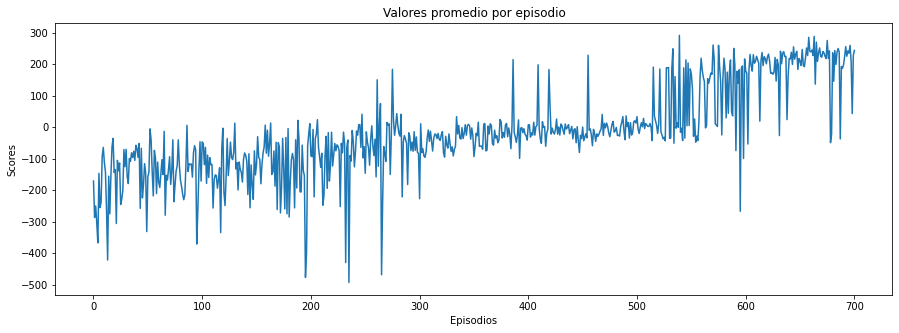

In [30]:
plt.figure(figsize=(15,5))
ax = sns.lineplot(x = np.arange(len(scores)), y = scores)
ax.set_title("Valores promedio por episodio")
ax.set_xlabel("Episodios")
ax.set_ylabel("Scores")

# Animacion del modelo con Video

In [31]:
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def show_video_of_model(agent, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()
        
        action = agent.act(state)

        state, reward, done, _ = env.step(action)        
    env.close()

In [32]:
#agent = Agent(state_size=8, action_size=4, seed=0)
show_video_of_model(agent, 'LunarLander-v2')

/Users/urvog/miniconda3/envs/envRLPytorch/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [33]:
show_video('LunarLander-v2')